In [1]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=0c7bf9ddc4529371544e746ad59951e8442dc4a83e0d82a3a1b638cc2d438988
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [9]:
import networkx as nx
from node2vec import Node2Vec

EMBEDDING_FILENAME="em_filename.txt"
EMBEDDING_MODEL_FILENAME="em_model"
EDGES_EMBEDDING_FILENAME="edg_em_file"

# Create a graph 
# graph = nx.fast_gnp_random_graph(n=10, p=0.5)
as_relation_file=open("as-rank.caida.peercones-with-IX-short.txt",'r')

graph = nx.Graph()
for line in as_relation_file:
     if line.startswith('#'):
         continue
     w = line.split('|')
     
     #graph.add_node(w[0], w[1])
     graph.add_edge(w[0], w[1])

# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed, `dimensions` and `workers` are automatically passed (from the Node2Vec constructor)

# Look for most similar nodes
model.wv.most_similar('2')  # Output node names are always strings

# Save embeddings for later use
model.wv.save_word2vec_format(EMBEDDING_FILENAME)

# Save model for later use
model.save(EMBEDDING_MODEL_FILENAME)

# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
#edges_embs[('1', '2')]
''' OUTPUT
array([ 5.75068220e-03, -1.10937878e-02,  3.76693785e-01,  2.69105062e-02,
       ... ... ....
       ..................................................................],
      dtype=float32)
'''

# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
#edges_kv.most_similar(str(('1', '2')))

# Save embeddings for later use
edges_kv.save_word2vec_format(EDGES_EMBEDDING_FILENAME)

Computing transition probabilities:   0%|          | 0/111 [00:00<?, ?it/s]

Generating edge features: 100%|██████████| 6216/6216.0 [00:00<00:00, 149750.97it/s]


In [ ]:
import sys
print(sys.version)

3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


In [12]:
!cat em_filename.txt

111 64
81 0.29878628 0.13368315 0.025757592 -0.022882022 -0.20807023 0.35704032 0.5092444 0.36729348 0.3250625 0.10736791 0.045245614 0.48788413 -0.034847345 -0.12164224 0.24030647 0.19578487 -0.24889806 -0.60654074 -0.074196376 0.2781954 0.005933358 -0.322091 0.0034010464 0.6703668 0.14658025 -0.19624767 -0.16563249 0.085726224 0.3111866 0.08043052 0.77239865 -0.0007475586 -0.07466015 0.1582177 0.7321515 -0.6968845 0.14741336 -0.3890679 -0.3920662 -0.1807269 0.5588629 -0.027804593 -0.10006575 -0.36820924 0.12172146 0.24177071 -0.21761926 -0.29571325 -0.4603423 0.0782879 -0.0765488 0.071916394 -0.5201053 0.6373902 -0.5497975 -0.25491157 -0.33558196 0.042301573 -0.36114612 -0.3421624 -0.2508457 -0.3787549 -0.08002079 -0.09739052
57 0.44178456 0.5125665 -0.22224966 0.2582528 0.15804857 0.38218394 0.23473856 0.19328105 0.06159839 0.037478458 0.39769086 0.63482875 -0.19082986 0.048714362 -0.32854664 -0.07962234 -0.37584615 -0.32426688 -0.3536209 -0.26479313 -0.43521285 0.018271329 0.240103

Algorytm t-SNE

*   algorytm nalezący do klasy manifold learning 
*   algorytm oblicza nową reprezentację danych uczących, ale nie zezwala na przekształcenie nowych danych (nie można zastosować do zbioru uczącego)
*   Ideą jest znalezienie dwuwymiarowej reprezentacji danych, która najlepiej zachowuje odległości pomiędzy punktami 
*   Rozpoczyna się od losowej dwuwymiarowej reprezentacji dla każdego punktu danych, a następnie próbuje zbliżyć punkty, które są blisko pierwotnej przestrzenii cech, a punkty położone daleko od siebie w pierwotnej przestrzenii cech są daleko od siebie




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ConversionWarning: Some errors were detected !
    Line #1 (got 2 columns instead of 64)
  


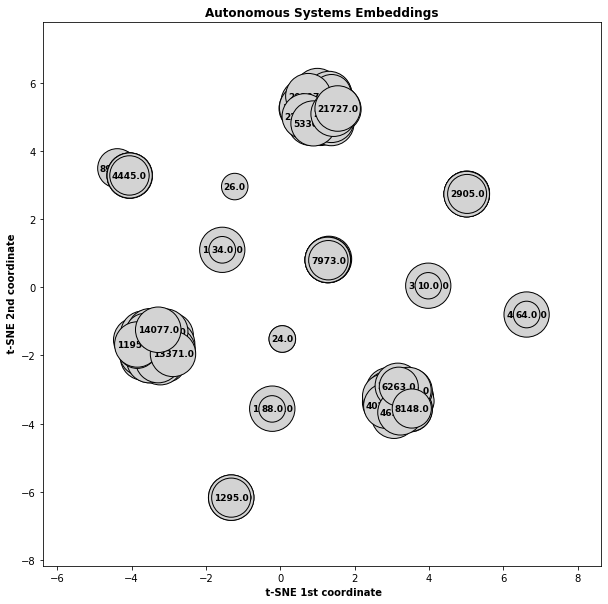

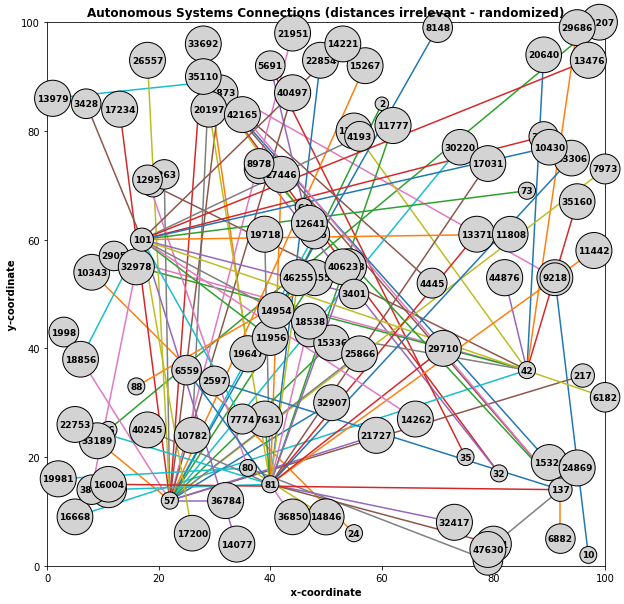

In [11]:
#@title t-SNE
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random 

# extracting data without id's
File_data = np.genfromtxt("em_filename.txt", dtype=float,invalid_raise = False,usecols=np.arange(1, 65))

# extracting id's from source file
as_labels = np.genfromtxt("em_filename.txt", dtype=float,invalid_raise = False,usecols=np.arange(0, 1))

# making embeddings 
embedding = TSNE(n_components=2,learning_rate='auto',init='random').fit_transform(File_data)

# plot limiting
plt.figure(figsize=(10,10))
plt.xlim(embedding[:,0].min()-2,embedding[:,0].max() + 2)
plt.ylim(embedding[:,1].min()-2,embedding[:,1].max() + 2)

# assigning numbers to points in plot 
for i in range(len(embedding)):
  plt.text(embedding[i,0],embedding[i,1],str(as_labels[i]),fontdict={'weight': 'bold', 'size': 9},ha="center", va="center",bbox = dict(boxstyle=f"circle,pad={0.25}", fc="lightgrey"))

# plotting
plt.xlabel(' t-SNE 1st coordinate',fontweight="bold")
plt.ylabel(' t-SNE 2nd coordinate', fontweight="bold")
plt.title('Autonomous Systems Embeddings',fontweight="bold")
plt.show()

# Connections plotting
plt.figure(figsize=(10,10))
plt.xlim(0,100)
plt.ylim(0,100)

node_list = {}

# randomizing AS locations in map
for i in graph.nodes:
  x_random = random.randint(0,100)
  y_random = random.randint(0,100)
  node_list[i]= ([x_random,y_random])  
  plt.text(x_random,y_random,str(i),fontdict={'weight': 'bold', 'size': 9},ha="center", va="center",bbox = dict(boxstyle=f"circle,pad={0.25}", fc="lightgrey"))

# Looking for edges
for j in graph.edges:
  plt.plot([node_list[j[0]][0],node_list[j[1]][0]],[node_list[j[0]][1],node_list[j[1]][1]])

plt.title('Autonomous Systems Connections (distances irrelevant - randomized)',fontweight="bold")

print()
print()

plt.xlabel(' x-coordinate ',fontweight="bold")
plt.ylabel(' y-coordinate ', fontweight="bold")
plt.show()